**Spark NLP for Multiclass Text Classification**


Spark NLP provides a single framework for all NLP needs. It is an open source NLP library build on top of Apache spark and Spark ML.It provides an easy way to integrate with ML pipelines



In [1]:
#installs Spark and pyspark
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2021-09-10 23:51:33--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-09-10 23:51:33--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.57K  --.-KB/s    in 0s      

2021-09-10 23:51:33 (34.8 MB/s) - written to stdout [1608/1608]

setup Cola

In [1]:
#load required packages
import os
import numpy as np
import pandas as pd
import sparknlp
import sys

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline

from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *


In [2]:
#start spark sessiom
spark = sparknlp.start() 



In [3]:
#load training data
 
training_df = pd.read_excel(open('training.xlsx', 'rb'),
              sheet_name='training')
training_df

,Organization - ID,Organization - Name,Organization - Website,Organization - CB Description,Organization - Company Type,Organization - CB Industries,Organization - Employee Range,Organization - New Industry,Keyword,MetaKeyword,MetaDescription,web_description,web_keywords
0,440,Aston Martin Lagonda,https://www.astonmartin.comen-us/,Aston Martin Lagonda Global Holdings manufactu...,Acquirer,"Automotive, Leisure, Manufacturing, Product De...",1001-5000,Automotive - Car Manufacturing,NaN,NaN,NaN,NaN,NaN
1,898,Fiat Chrysler Auto,https://www.fcagroup.comen-US/Pages/home.aspx,"Fiat Chrysler Automobiles designs, engineers, ...",Acquirer,"Automotive, Industrial Manufacturing, Manufact...",10001+,Automotive - Car Manufacturing,NaN,NaN,NaN,NaN,NaN
2,930,Ford Motor Company,https://www.ford.com,"Ford Motor Company, an automotive company, dev...",Acquirer,"Apps, Automotive, Manufacturing, Transportation",10001+,Automotive - Car Manufacturing,access,NaN,NaN,FordÃ‚Â® is Built for America. Discover the la...,NaN
3,965,General Motors Company,https://www.gm.com,General Motors is a Detroit-based mutinational...,Acquirer,"Automotive, Enterprise Software, Manufacturing...",10001+,Automotive - Car Manufacturing,access,NaN,NaN,"General Motors is home to Chevrolet, Buick, GM...",NaN
4,296,AARP,http://www.aarp.org,NaN,Acquirer,NaN,NaN,"Civic, Non-Profit and Membership Groups","benefits, website, leaving, provider, cancel, ...",NaN,NaN,"AARP is the nation's largest nonprofit, nonpar...","aarp, real possibilities, baby boomers, driver..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120,1157,JetBlue,https://www.jetblue.com,JetBlue airways to bring humanity back to air ...,Acquirer,Transportation,10001+,Transportation - Airline,NaN,NaN,NaN,JetBlue offers flights to 90+ destinations wit...,"JetBlue airline, flights, vacations, low airfa..."
2121,1743,Southwest Airlines,https://www.southwest.com,Southwest Airlines (NYSE: LUV) continues to di...,Acquirer,Public Transportation,10001+,Transportation - Airline,NaN,NaN,NaN,Find low fares to top destinations on the offi...,NaN
2122,1933,United Continental Holdings,https://www.united.comen/us,United Airlines and United Express operate app...,Acquirer,"Aerospace, Hospitality, In-Flight Entertainmen...",10001+,Transportation - Airline,NaN,NaN,NaN,NaN,NaN
2123,894,FedEx Corporation,https://www.fedex.comen-us/home.html,FedEx Corporation provides customers and busin...,Acquirer,"Commercial Real Estate, E-Commerce, Logistics,...",10001+,Transportation - Shipping,NaN,NaN,NaN,NaN,NaN


In [4]:
#rename columns
training_df.columns=['org_id','org_name','org_website','org_cb_description','org_company_type','org_cb_industry','org_company_size','org_new_industry','keyword','metakeyword','metadesc','webdesc','webkeyword']

#remove columns not part of the study
drop_col=['org_id','org_name','org_website','org_company_type','org_cb_industry','org_company_size']
training_df.drop(columns=drop_col,axis=1, inplace=True)
training_df


,org_cb_description,org_new_industry,keyword,metakeyword,metadesc,webdesc,webkeyword
0,Aston Martin Lagonda Global Holdings manufactu...,Automotive - Car Manufacturing,NaN,NaN,NaN,NaN,NaN
1,"Fiat Chrysler Automobiles designs, engineers, ...",Automotive - Car Manufacturing,NaN,NaN,NaN,NaN,NaN
2,"Ford Motor Company, an automotive company, dev...",Automotive - Car Manufacturing,access,NaN,NaN,FordÃ‚Â® is Built for America. Discover the la...,NaN
3,General Motors is a Detroit-based mutinational...,Automotive - Car Manufacturing,access,NaN,NaN,"General Motors is home to Chevrolet, Buick, GM...",NaN
4,NaN,"Civic, Non-Profit and Membership Groups","benefits, website, leaving, provider, cancel, ...",NaN,NaN,"AARP is the nation's largest nonprofit, nonpar...","aarp, real possibilities, baby boomers, driver..."
...,...,...,...,...,...,...,...
2120,JetBlue airways to bring humanity back to air ...,Transportation - Airline,NaN,NaN,NaN,JetBlue offers flights to 90+ destinations wit...,"JetBlue airline, flights, vacations, low airfa..."
2121,Southwest Airlines (NYSE: LUV) continues to di...,Transportation - Airline,NaN,NaN,NaN,Find low fares to top destinations on the offi...,NaN
2122,United Airlines and United Express operate app...,Transportation - Airline,NaN,NaN,NaN,NaN,NaN
2123,FedEx Corporation provides customers and busin...,Transportation - Shipping,NaN,NaN,NaN,NaN,NaN


In [2]:
#drop rows for NA's in org_new_industry
training_df = training_df[training_df['org_new_industry'].notna()]


NameError: ignored

In [6]:
#description combined is the document to be classified
training_df['description_combined'] = training_df[['org_cb_description', 'keyword', 'metakeyword','metadesc','webdesc','webkeyword']].fillna('').agg(' '.join, axis=1)
training_df['description_combined']

0       Aston Martin Lagonda Global Holdings manufactu...
1       Fiat Chrysler Automobiles designs, engineers, ...
2       Ford Motor Company, an automotive company, dev...
3       General Motors is a Detroit-based mutinational...
4        benefits, website, leaving, provider, cancel,...
                              ...                        
2120    JetBlue airways to bring humanity back to air ...
2121    Southwest Airlines (NYSE: LUV) continues to di...
2122    United Airlines and United Express operate app...
2123    FedEx Corporation provides customers and busin...
2124    United Parcel Service (UPS) is a package deliv...
Name: description_combined, Length: 2125, dtype: object

In [7]:
#drop rows for NA's in description
training_df = training_df[training_df['description_combined'].notna()]

In [8]:
train_df=training_df.loc[:,['org_new_industry','description_combined']]
train_df

,org_new_industry,description_combined
0,Automotive - Car Manufacturing,Aston Martin Lagonda Global Holdings manufactu...
1,Automotive - Car Manufacturing,"Fiat Chrysler Automobiles designs, engineers, ..."
2,Automotive - Car Manufacturing,"Ford Motor Company, an automotive company, dev..."
3,Automotive - Car Manufacturing,General Motors is a Detroit-based mutinational...
4,"Civic, Non-Profit and Membership Groups","benefits, website, leaving, provider, cancel,..."
...,...,...
2120,Transportation - Airline,JetBlue airways to bring humanity back to air ...
2121,Transportation - Airline,Southwest Airlines (NYSE: LUV) continues to di...
2122,Transportation - Airline,United Airlines and United Express operate app...
2123,Transportation - Shipping,FedEx Corporation provides customers and busin...


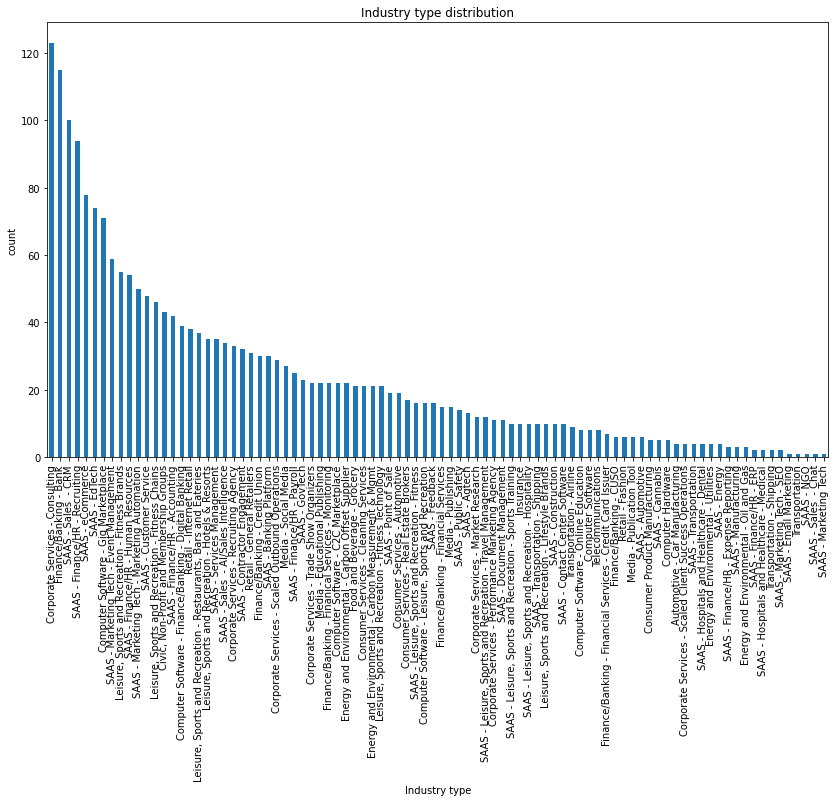

In [10]:
#Check class distribution
import matplotlib.pyplot as plt
ax = train_df["org_new_industry"].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Industry type distribution")
ax.set_xlabel("Industry type")
ax.set_ylabel("count")
plt.show()

In [32]:

#train_df=train_df.groupby('org_new_industry').filter(lambda x : len(x)>9)

In [12]:
#train_df.loc[train_df['org_new_industry'].str.contains("SAAS - Leisure"),'org_new_industry'] = 'SAAS - Leisure, Sports and Recreation - Fitness'

In [11]:
train_df["org_new_industry"].value_counts()

Corporate Services - Consulting    123
Finance/Banking - Bank             115
SAAS - Sales  - CRM                100
SAAS - Finance/HR - Recruiting      94
SAAS - eCommerce                    78
                                  ... 
SAAS - Email Marketing               1
Transportation                       1
SAAS - NGO                           1
SAAS - Sales  - Chat                 1
SAAS - Marketing Tech                1
Name: org_new_industry, Length: 90, dtype: int64

In [9]:
#Seperate majority class and minority
train_df_major=train_df.groupby('org_new_industry').filter(lambda x : len(x)>10)
train_df_major["org_new_industry"].value_counts()





Corporate Services - Consulting                                    123
Finance/Banking - Bank                                             115
SAAS - Sales  - CRM                                                100
SAAS - Finance/HR - Recruiting                                      94
SAAS - eCommerce                                                    78
SAAS - EdTech                                                       74
Computer Software - Gig Marketplace                                 71
SAAS - Marketing Tech - Event Management                            59
Leisure, Sports and Recreation - Fitness Brands                     55
SAAS - Finance/HR - Human Resources                                 54
SAAS - Marketing Tech - Marketing Automation                        50
SAAS - Customer Service                                             48
Leisure, Sports and Recreation - Fitness Chains                     46
Civic, Non-Profit and Membership Groups                             43
SAAS -

In [10]:
train_df_minor=train_df.groupby('org_new_industry').filter(lambda x : len(x)<10 )
train_df_minor["org_new_industry"].value_counts()


Transportation - Airline                                     9
Computer Software - Online Education                         8
Telecommunications                                           8
Computer Software                                            8
Finance/Banking - Financial Services - Credit Card Issuer    7
Retail - Fashion                                             6
Media - Publication Tool                                     6
SAAS - Automotive                                            6
Finance/Banking - CUSO                                       6
Computer Hardware                                            5
SAAS - Cannabis                                              5
Consumer Product Manufacturing                               5
SAAS - Transportation                                        4
SAAS - Energy                                                4
Automotive - Car Manufacturing                               4
Corporate Services - Scaled Client Success Operations  

In [14]:
train_df_major["org_new_industry"].value_counts()

Corporate Services - Consulting                                    123
Finance/Banking - Bank                                             115
SAAS - Sales  - CRM                                                100
SAAS - Finance/HR - Recruiting                                      94
SAAS - eCommerce                                                    78
SAAS - EdTech                                                       74
Computer Software - Gig Marketplace                                 71
SAAS - Marketing Tech - Event Management                            59
Leisure, Sports and Recreation - Fitness Brands                     55
SAAS - Finance/HR - Human Resources                                 54
SAAS - Marketing Tech - Marketing Automation                        50
SAAS - Customer Service                                             48
Leisure, Sports and Recreation - Fitness Chains                     46
Civic, Non-Profit and Membership Groups                             43
SAAS -

In [11]:
from sklearn.utils import resample
train_df_minor_upsampled = resample(train_df_minor, 
                                 replace=True,     # sample with replacement
                                 n_samples=3000,    # to match majority class
                                 random_state=123) 



In [12]:
#combine majority class with upsampled minority class
train_df=pd.concat([train_df_major, train_df_minor_upsampled])


(4930, 2)

In [18]:
train_df["org_new_industry"].value_counts()

Transportation - Airline                                     202
Telecommunications                                           199
Computer Software - Online Education                         192
Computer Software                                            186
Finance/Banking - Financial Services - Credit Card Issuer    163
                                                            ... 
SAAS - Agtech                                                 13
SAAS - Leisure, Sports and Recreation - Travel Management     12
Corporate Services - Market Research                          12
Corporate Services - Performance Marketing Agency             11
SAAS - Document Management                                    11
Name: org_new_industry, Length: 83, dtype: int64

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[1]") \
    .appName("SparkByExamples.com") \
    .getOrCreate()

train_sparkdf=spark.createDataFrame(train_df) 

Text Classification with Classifier with SparkNLP

 Code for SparkNLP modified from JohnSnowLabs tutorials https://github.com/JohnSnowLabs/spark-nlp-workshop 

In [ ]:
document = DocumentAssembler()\
    .setInputCol("description_combined")\
    .setOutputCol("document")

In [ ]:
use = UniversalSentenceEncoder.pretrained()\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [ ]:
classsifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("org_new_industry")\
  .setMaxEpochs(100)\
  .setEnableOutputLogs(True)

In [ ]:
use_clf_pipeline = Pipeline(
    stages = [
        document,
        use,
        classsifierdl
    ])

In [ ]:
use_pipelineModel = use_clf_pipeline.fit(train_sparkdf)

In [ ]:
#Check the log file for accuracy
!cat /root/annotator_logs/ClassifierDLApproach_be988989c0da.log

Training started - epochs: 10 - learning_rate: 0.005 - batch_size: 64 - training_examples: 1408 - classes: 57
Epoch 0/10 - 0.91s - loss: 86.350716 - acc: 0.06392045 - batches: 22
Epoch 1/10 - 0.49s - loss: 85.34599 - acc: 0.06534091 - batches: 22
Epoch 2/10 - 0.50s - loss: 85.20158 - acc: 0.06534091 - batches: 22
Epoch 3/10 - 0.49s - loss: 85.18302 - acc: 0.07457387 - batches: 22
Epoch 4/10 - 0.44s - loss: 85.15109 - acc: 0.09090909 - batches: 22
Epoch 5/10 - 0.46s - loss: 85.31926 - acc: 0.09090909 - batches: 22
Epoch 6/10 - 0.44s - loss: 85.45742 - acc: 0.09090909 - batches: 22
Epoch 7/10 - 0.42s - loss: 85.69988 - acc: 0.09090909 - batches: 22
Epoch 8/10 - 0.41s - loss: 85.692604 - acc: 0.09090909 - batches: 22
Epoch 9/10 - 0.42s - loss: 85.70982 - acc: 0.09090909 - batches: 22


Bert Sentence Embedding 

In [ ]:
document = DocumentAssembler()\
    .setInputCol("description_combined")\
    .setOutputCol("document")

In [ ]:
bert_sent=BertSentenceEmbeddings.pretrained("sent_small_bert_L8_512")\
.setInputCols(["document"])\
.setOutputCol("sentence_embeddings")

sent_small_bert_L8_512 download started this may take some time.
Approximate size to download 149.1 MB
[OK!]


In [ ]:
classsifierd2 = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("org_new_industry")\
  .setMaxEpochs(20)\
  .setEnableOutputLogs(True)

In [ ]:
bert_sent_clf_pipeline=Pipeline(
    stages=
    [document,bert_sent,classsifierd2])

In [ ]:
bert_sentPiplelineModel=bert_sent_clf_pipeline.fit(train_sparkdf)

In [ ]:
!cat /root/annotator_logs/ClassifierDLApproach_e03f35e43850.log

Training started - epochs: 100 - learning_rate: 0.005 - batch_size: 64 - training_examples: 2000 - classes: 57
Epoch 0/100 - 0.79s - loss: 127.83613 - acc: 0.07711694 - batches: 32
Epoch 1/100 - 0.50s - loss: 127.5002 - acc: 0.10483871 - batches: 32
Epoch 2/100 - 0.49s - loss: 126.309616 - acc: 0.11391129 - batches: 32
Epoch 3/100 - 0.47s - loss: 126.31585 - acc: 0.11794355 - batches: 32
Epoch 4/100 - 0.50s - loss: 126.34202 - acc: 0.11794355 - batches: 32
Epoch 5/100 - 0.51s - loss: 126.31132 - acc: 0.12096774 - batches: 32
Epoch 6/100 - 0.51s - loss: 126.31459 - acc: 0.11945564 - batches: 32
Epoch 7/100 - 0.49s - loss: 126.28653 - acc: 0.12247984 - batches: 32
Epoch 8/100 - 0.50s - loss: 126.196724 - acc: 0.12298387 - batches: 32
Epoch 9/100 - 0.53s - loss: 126.078224 - acc: 0.123487905 - batches: 32
Epoch 10/100 - 0.49s - loss: 125.960625 - acc: 0.123487905 - batches: 32
Epoch 11/100 - 0.49s - loss: 125.74481 - acc: 0.13004032 - batches: 32
Epoch 12/100 - 0.50s - loss: 125.35416 - a

Using Glove Embeddings

In [33]:
document_assembler = DocumentAssembler() \
    .setInputCol("description_combined") \
    .setOutputCol("document")
    
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")
      
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
    .setInputCols("normalized")\
    .setOutputCol("cleanTokens")\
    .setCaseSensitive(False)

lemma = LemmatizerModel.pretrained('lemma_antbnc') \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("lemma")




lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [34]:
glove_embeddings = WordEmbeddingsModel().pretrained() \
      .setInputCols(["document",'lemma'])\
      .setOutputCol("embeddings")\
      .setCaseSensitive(False)

embeddingsSentence = SentenceEmbeddings() \
      .setInputCols(["document", "embeddings"]) \
      .setOutputCol("sentence_embeddings") \
      .setPoolingStrategy("AVERAGE")

classsifierd3 = ClassifierDLApproach()\
      .setInputCols(["sentence_embeddings"])\
      .setOutputCol("class")\
      .setLabelColumn("org_new_industry")\
      .setMaxEpochs(150)\
      .setEnableOutputLogs(True)
      #.setOutputLogsPath('logs')

clf_pipeline = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            lemma, 
            glove_embeddings,
            embeddingsSentence,
            classsifierd3])

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [35]:
clf_pipelineModel = clf_pipeline.fit(train_sparkdf)

In [36]:
!cat /root/annotator_logs/ClassifierDLApproach_9c336719bc43.log

Training started - epochs: 150 - learning_rate: 0.005 - batch_size: 64 - training_examples: 4930 - classes: 83
Epoch 0/150 - 1.65s - loss: 340.80334 - acc: 0.1434659 - batches: 78
Epoch 1/150 - 1.14s - loss: 330.56232 - acc: 0.26704547 - batches: 78
Epoch 2/150 - 1.11s - loss: 328.5298 - acc: 0.2924107 - batches: 78
Epoch 3/150 - 1.08s - loss: 328.1712 - acc: 0.29383117 - batches: 78
Epoch 4/150 - 1.06s - loss: 328.1233 - acc: 0.29383117 - batches: 78
Epoch 5/150 - 1.05s - loss: 328.10086 - acc: 0.29383117 - batches: 78
Epoch 6/150 - 1.03s - loss: 328.0877 - acc: 0.29383117 - batches: 78
Epoch 7/150 - 1.02s - loss: 328.07816 - acc: 0.29383117 - batches: 78
Epoch 8/150 - 1.06s - loss: 328.07056 - acc: 0.29383117 - batches: 78
Epoch 9/150 - 1.08s - loss: 328.06433 - acc: 0.29383117 - batches: 78
Epoch 10/150 - 1.06s - loss: 328.05917 - acc: 0.29383117 - batches: 78
Epoch 11/150 - 1.11s - loss: 328.05505 - acc: 0.29383117 - batches: 78
Epoch 12/150 - 1.04s - loss: 328.05167 - acc: 0.29383

Logistic Regression

In [19]:
#Text preprocessig Spark NLP, Count Vectorizer and Logistic Regression
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF, OneHotEncoder, StringIndexer, VectorAssembler, SQLTransformer
document_assembler = DocumentAssembler() \
    .setInputCol("description_combined") \
    .setOutputCol("document")
    
tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")
      
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
    .setInputCols("normalized")\
    .setOutputCol("cleanTokens")\
    .setCaseSensitive(False)

lemma = LemmatizerModel.pretrained('lemma_antbnc') \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("lemma")

finisher = Finisher() \
      .setInputCols(["lemma"]) \
      .setOutputCols(["token_features"]) \
      .setOutputAsArray(True) \
      .setCleanAnnotations(False)

countVectors = CountVectorizer(inputCol="token_features", outputCol="features", vocabSize=10000, minDF=5)
label_stringIdx = StringIndexer(inputCol = "org_new_industry", outputCol = "label")
nlp_pipeline = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            lemma, 
            finisher,
            countVectors,
            label_stringIdx])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [22]:
nlp_model = nlp_pipeline.fit(train_sparkdf)
processed = nlp_model.transform(train_sparkdf)

processed.count()

4930

In [23]:
(trainingData, testData) = processed.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 3430
Test Dataset Count: 1500


In [24]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0)

lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 32.0) \
    .select("description_combined","org_new_industry","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-----------------------+------------------------------+-----+----------+
|          description_combined|       org_new_industry|                   probability|label|prediction|
+------------------------------+-----------------------+------------------------------+-----+----------+
| business, digital, sapphir...|SAAS - Finance/HR - ERP|[0.010163164404573878,0.011...| 32.0|      32.0|
| business, digital, sapphir...|SAAS - Finance/HR - ERP|[0.010163164404573878,0.011...| 32.0|      32.0|
| business, digital, sapphir...|SAAS - Finance/HR - ERP|[0.010163164404573878,0.011...| 32.0|      32.0|
| business, digital, sapphir...|SAAS - Finance/HR - ERP|[0.010163164404573878,0.011...| 32.0|      32.0|
| business, digital, sapphir...|SAAS - Finance/HR - ERP|[0.010163164404573878,0.011...| 32.0|      32.0|
| business, digital, sapphir...|SAAS - Finance/HR - ERP|[0.010163164404573878,0.011...| 32.0|      32.0|
| business, digital, sapphir...|SAAS - Finance/HR - ERP

In [25]:

#Evaluate multiclass predictions
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

evaluator.evaluate(predictions)

0.6621127368480232

In [30]:

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

In [27]:

confusion_matrix = confusion_matrix(list(y_true.label.astype(int)), list(y_pred.prediction.astype(int)))
confusion_matrix

array([[26,  1,  0, ...,  0,  0,  0],
       [ 5, 19,  0, ...,  0,  0,  0],
       [ 1,  0, 19, ...,  0,  0,  0],
       ...,
       [ 3,  2,  0, ...,  0,  0,  0],
       [ 2,  0,  0, ...,  0,  1,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [31]:
print(classification_report(y_true.label, y_pred.prediction))
print(accuracy_score(y_true.label, y_pred.prediction))

              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86        64
         1.0       0.26      1.00      0.41        55
         2.0       0.56      0.84      0.67        51
         3.0       0.80      0.77      0.78        56
         4.0       0.93      1.00      0.96        54
         5.0       0.97      0.77      0.86        48
         6.0       0.81      0.85      0.83        34
         7.0       0.96      1.00      0.98        45
         8.0       0.97      1.00      0.99        37
         9.0       0.96      1.00      0.98        47
        10.0       0.24      0.69      0.36        26
        11.0       0.49      0.76      0.59        29
        12.0       1.00      1.00      1.00        33
        13.0       0.97      1.00      0.99        34
        14.0       0.95      1.00      0.97        37
        15.0       0.32      0.41      0.36        34
        16.0       0.92      1.00      0.96        23
        17.0       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression with TF-IDF


In [26]:

from pyspark.ml.feature import HashingTF, IDF

hashingTF = HashingTF(inputCol="token_features", outputCol="rawFeatures", numFeatures=10000)

idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms

nlp_pipeline_tf = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            lemma, 
            finisher,
            hashingTF,
            idf,
            label_stringIdx])

nlp_model_tf = nlp_pipeline_tf.fit(train_sparkdf)

processed_tf = nlp_model_tf.transform(train_sparkdf)

processed_tf.count()

4930

In [40]:
processed_tf.select('description_combined','features','label').show()

+--------------------+--------------------+-----+
|description_combined|            features|label|
+--------------------+--------------------+-----+
| benefits, websit...|(10000,[70,116,13...| 37.0|
| union, workers, ...|(10000,[36,557,82...| 37.0|
| cancer, research...|(10000,[116,157,3...| 37.0|
| science, public,...|(10000,[387,573,5...| 37.0|
| chemistry, award...|(10000,[71,217,32...| 37.0|
| diabetes, overvi...|(10000,[125,710,1...| 37.0|
| bureau, advocacy...|(10000,[120,178,3...| 37.0|
| afscme, union, w...|(10000,[228,272,5...| 37.0|
| randi, president...|(10000,[855,1306,...| 37.0|
|The American Psyc...|(10000,[393,743,7...| 37.0|
|This is the missi...|(10000,[29,80,116...| 37.0|
| health, union, r...|(10000,[178,228,3...| 37.0|
| scouts, girls, s...|(10000,[72,573,59...| 37.0|
| animals, humane,...|(10000,[327,630,7...| 37.0|
| power, media, de...|(10000,[228,1209,...| 37.0|
| teamsters, divis...|(10000,[188,228,3...| 37.0|
|    IUOE provides...|(10000,[47,306,55...| 37.0|


In [27]:

(trainingData, testData) = processed_tf.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 3430
Test Dataset Count: 1500


In [28]:

lrModel_tf = lr.fit(trainingData)

predictions_tf = lrModel_tf.transform(testData)

predictions_tf.select("description_combined","org_new_industry","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 20, truncate = 30)

+------------------------------+------------------------+------------------------------+-----+----------+
|          description_combined|        org_new_industry|                   probability|label|prediction|
+------------------------------+------------------------+------------------------------+-----+----------+
|Hawaiian provides single-ca...|Transportation - Airline|[0.9854912495506277,3.99101...|  0.0|       0.0|
|Hawaiian provides single-ca...|Transportation - Airline|[0.9854912495506277,3.99101...|  0.0|       0.0|
|Hawaiian provides single-ca...|Transportation - Airline|[0.9854912495506277,3.99101...|  0.0|       0.0|
|Hawaiian provides single-ca...|Transportation - Airline|[0.9854912495506277,3.99101...|  0.0|       0.0|
|Hawaiian provides single-ca...|Transportation - Airline|[0.9854912495506277,3.99101...|  0.0|       0.0|
|Hawaiian provides single-ca...|Transportation - Airline|[0.9854912495506277,3.99101...|  0.0|       0.0|
|JetBlue airways to bring hu...|Transportation

In [32]:

y_true = predictions_tf.select("label")
y_true = y_true.toPandas()

y_pred = predictions_tf.select("prediction")
y_pred = y_pred.toPandas()

print(classification_report(y_true.label, y_pred.prediction))
print(accuracy_score(y_true.label, y_pred.prediction))

              precision    recall  f1-score   support

         0.0       0.74      1.00      0.85        64
         1.0       0.27      1.00      0.42        55
         2.0       0.49      0.84      0.62        51
         3.0       0.77      0.77      0.77        56
         4.0       0.92      1.00      0.96        54
         5.0       0.95      0.77      0.85        48
         6.0       0.78      0.85      0.82        34
         7.0       0.94      1.00      0.97        45
         8.0       0.97      1.00      0.99        37
         9.0       0.96      1.00      0.98        47
        10.0       0.24      0.65      0.35        26
        11.0       0.46      0.66      0.54        29
        12.0       0.97      1.00      0.99        33
        13.0       0.94      1.00      0.97        34
        14.0       0.90      1.00      0.95        37
        15.0       0.33      0.47      0.39        34
        16.0       0.88      1.00      0.94        23
        17.0       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Random Forest with TFIDF

In [34]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)

# Train model with Training Data
rfModel = rf.fit(trainingData)
predictions_rf = rfModel.transform(testData)

In [35]:
predictions_rf.select("description_combined","org_new_industry","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+------------------------------+------------------------------+-----+----------+
|          description_combined|              org_new_industry|                   probability|label|prediction|
+------------------------------+------------------------------+------------------------------+-----+----------+
| black, veatch, management,...|Corporate Services - Consul...|[0.16196282531599457,0.0824...|  0.0|       0.0|
| overview, projects, recent...|Corporate Services - Consul...|[0.14397670547986222,0.0661...|  0.0|       0.0|
| water, projects, carollo, ...|Corporate Services - Consul...|[0.12673924328903607,0.0497...|  0.0|       0.0|
| professor, research, econo...|Corporate Services - Consul...|[0.12578155357312987,0.1148...|  0.0|       0.0|
|Arup is an independent firm...|Energy and Environmental - ...|[0.12168340824457735,0.0493...| 36.0|       0.0|
| gilbane, company, building...|Corporate Services - Consul...|[0.11886669744587075,0.0538...|  0.0|    

In [36]:
y_true = predictions_rf.select("label")
y_true = y_true.toPandas()

y_pred = predictions_rf.select("prediction")
y_pred = y_pred.toPandas()

print(classification_report(y_true.label, y_pred.prediction))
print(accuracy_score(y_true.label, y_pred.prediction))

              precision    recall  f1-score   support

         0.0       0.09      1.00      0.16        31
         1.0       0.23      0.79      0.36        24
         2.0       0.41      0.33      0.37        33
         3.0       0.68      0.45      0.54        29
         4.0       0.67      0.48      0.56        25
         5.0       0.58      0.73      0.64        26
         6.0       0.00      0.00      0.00        23
         7.0       0.67      0.44      0.53        18
         8.0       0.00      0.00      0.00        19
         9.0       0.67      0.29      0.40        14
        10.0       0.00      0.00      0.00        15
        11.0       0.00      0.00      0.00        13
        12.0       0.00      0.00      0.00         9
        13.0       0.00      0.00      0.00        15
        14.0       0.00      0.00      0.00        12
        15.0       0.00      0.00      0.00        10
        16.0       0.00      0.00      0.00        13
        17.0       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Logistic Regression with Universal Sentence Encoder

In [14]:
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF, OneHotEncoder, StringIndexer, VectorAssembler, SQLTransformer
useEmbeddings = UniversalSentenceEncoder.pretrained()\
      .setInputCols("document")\
      .setOutputCol("use_embeddings")

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [15]:

document_assembler = DocumentAssembler() \
      .setInputCol("description_combined") \
      .setOutputCol("document")

loaded_useEmbeddings = UniversalSentenceEncoder.load('/root/cache_pretrained/tfhub_use_en_2.4.0_2.4_1587136330099')\
      .setInputCols("document")\
      .setOutputCol("use_embeddings")

embeddings_finisher = EmbeddingsFinisher() \
      .setInputCols(["use_embeddings"]) \
      .setOutputCols(["finished_use_embeddings"]) \
      .setOutputAsVector(True)\
      .setCleanAnnotations(False)

label_stringIdx = StringIndexer(inputCol = "org_new_industry", outputCol = "label")

use_pipeline = Pipeline(
      stages=[
        document_assembler,
        loaded_useEmbeddings,
        embeddings_finisher,
        label_stringIdx]
      )

use_df = use_pipeline.fit(train_sparkdf).transform(train_sparkdf)

In [16]:
from pyspark.sql.functions import explode

use_df= use_df.withColumn("features", explode(use_df.finished_use_embeddings))

In [23]:
use_df.show(2)

+--------------------+--------------------+--------------------+--------------------+-----------------------+-----+--------------------+
|    org_new_industry|description_combined|            document|      use_embeddings|finished_use_embeddings|label|            features|
+--------------------+--------------------+--------------------+--------------------+-----------------------+-----+--------------------+
|Civic, Non-Profit...| benefits, websit...|[{document, 0, 24...|[{sentence_embedd...|   [[-0.052313111722...| 37.0|[-0.0523131117224...|
|Civic, Non-Profit...| union, workers, ...|[{document, 0, 44...|[{sentence_embedd...|   [[-0.055451113730...| 37.0|[-0.0554511137306...|
+--------------------+--------------------+--------------------+--------------------+-----------------------+-----+--------------------+
only showing top 2 rows



In [17]:
(trainingData, testData) = use_df.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 3430
Test Dataset Count: 1500


In [18]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)

predictions.filter(predictions['prediction'] == 0) \
    .select("description_combined","org_new_industry","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 20, truncate = 30)

+------------------------------+------------------------+------------------------------+-----+----------+
|          description_combined|        org_new_industry|                   probability|label|prediction|
+------------------------------+------------------------+------------------------------+-----+----------+
|United Airlines and United ...|Transportation - Airline|[0.9122416670426028,0.00759...|  0.0|       0.0|
|United Airlines and United ...|Transportation - Airline|[0.9122416670426028,0.00759...|  0.0|       0.0|
|United Airlines and United ...|Transportation - Airline|[0.9122416670426028,0.00759...|  0.0|       0.0|
|United Airlines and United ...|Transportation - Airline|[0.9122416670426028,0.00759...|  0.0|       0.0|
|United Airlines and United ...|Transportation - Airline|[0.9122416670426028,0.00759...|  0.0|       0.0|
|United Airlines and United ...|Transportation - Airline|[0.9122416670426028,0.00759...|  0.0|       0.0|
|United Airlines and United ...|Transportation

In [20]:
df_pred = predictions.select('description_combined','org_new_industry','label','prediction').toPandas()
df_pred.head()

,description_combined,org_new_industry,label,prediction
0,General Motors is a Detroit-based mutinational...,Automotive - Car Manufacturing,12.0,12.0
1,"animals, humane, society, united, states, fig...","Civic, Non-Profit and Membership Groups",37.0,37.0
2,"benefits, website, leaving, provider, cancel,...","Civic, Non-Profit and Membership Groups",37.0,8.0
3,"carpenters, training, members, brotherhood, u...","Civic, Non-Profit and Membership Groups",37.0,10.0
4,"championships, youth, bowling, league, tourna...","Civic, Non-Profit and Membership Groups",37.0,1.0


In [21]:
print(classification_report(df_pred.label, df_pred.prediction))
print(accuracy_score(df_pred.label, df_pred.prediction))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        64
         1.0       0.74      0.93      0.82        55
         2.0       0.77      0.84      0.80        51
         3.0       0.33      0.84      0.47        56
         4.0       0.86      1.00      0.92        54
         5.0       0.79      0.77      0.78        48
         6.0       0.56      0.85      0.67        34
         7.0       0.79      1.00      0.88        45
         8.0       0.74      1.00      0.85        37
         9.0       0.81      1.00      0.90        47
        10.0       0.24      0.65      0.35        26
        11.0       0.60      0.83      0.70        29
        12.0       0.92      1.00      0.96        33
        13.0       0.77      1.00      0.87        34
        14.0       0.95      1.00      0.97        37
        15.0       0.30      0.41      0.35        34
        16.0       0.74      1.00      0.85        23
        17.0       0.86    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
